In [1]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [12]:
#load data

#manually add columns
cols = ['id','clump thickness','cell size','cell shape','adhesion','epithalamus size','bare nucleus','chromatin','normal nucleus','mitoses','class']
Data = pd.read_csv('./DummyDataSet/breast-cancer-wisconsin.data',names = cols)

#replace nulls with zeros and sort acc to class
cleanedData =Data.replace(to_replace = '?',value = 0);
sortedData = cleanedData.sort_values('class')

#split train and test, so all anomalies lie in test set
trainData = sortedData[:420]
testData = sortedData[420:]

#the 1st and last columns are id and label, which are not parameters used to learn
params = cols[1:-1]

In [13]:
def extract_normalized_imu_data(Data, params):
    """
    Extracts only the normal distribution z scores 
    of from the data
    input = Data, parameters
    """
    ParamsData = Data.loc[:, params]
    normData = (ParamsData - ParamsData.mean())/ParamsData.std()
    return normData

def find_theta_score(Data,dims=1):
    """
    Converts n dimensions to a lower dimensional score,
    for easier visualization
    """
    pca = PCA(n_components=dims)
    pca.fit(Data)
    theta_score = pca.transform(Data)
    return theta_score

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    plt.figure(figsize=(20,7))
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)

def plot_anomalies_in_2D(z2_score, anomalyPrediction):
    """
    plots z1 and z2 as a scatter plot on x and y axes respectively,
    with anomalies as red points and normal instances as blue
    """
    plt.figure(2)
    plt.figure(figsize=(20,7))
    for i in range(len(z2_score.T)):
        if anomalyPrediction[i]:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'r')
        else:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'b')
    
    
def generate_metrics(anomalyPrediction,testDataLabel):
    """
    generates accuracy and detection rate metrics, takes
    into input the prediction and the label column of the data
    lengths of the two vectors must match
    """
    actual_value = testDataLabel == 4
    #how many readings match
    N_set = anomalyPrediction == actual_value
    
    accuracy = sum(N_set)/len(testDataLabel)
    detection_rate = sum(anomalyPrediction)/sum(actual_value)
    false_positives = sum(np.logical_and((np.invert(actual_value)), anomalyPrediction))/len(testDataLabel)
    false_negatives = sum(np.logical_and(actual_value, np.invert(anomalyPrediction)))/len(testDataLabel)
    print('accuracy = ', accuracy,',detection rate =', detection_rate,'\nfalse positive rate = '
          ,false_positives,',false negative rate =',false_negatives)


In [14]:
#preprocess, decompose to 1D and 2D
z_score = find_theta_score(testData[params])

z2_score = find_theta_score(testData[params],2).T


/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


accuracy =  0.6738351254480287 ,detection rate = 0.6224066390041494 
false positive rate =  0.0 ,false negative rate = 0.32616487455197135


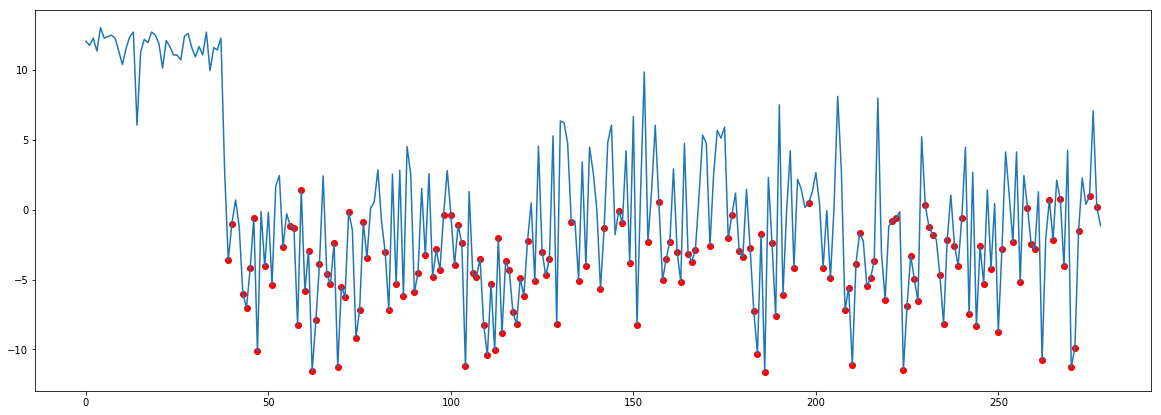

<Figure size 432x288 with 0 Axes>

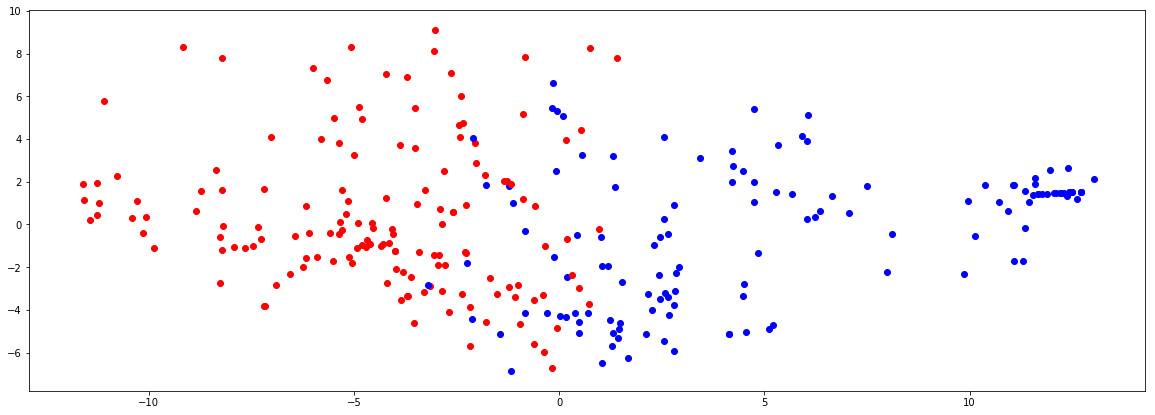

In [15]:
#using IsoFo

#add your algos in this very format pls

from sklearn.ensemble import IsolationForest

#fit isofo model
clf = IsolationForest(n_estimators=100,contamination = 0) #contamination parameter specifies the level of contamination in training data
clf.fit(trainData[params])

#predict anomalies
tempanomalyPrediction = clf.predict(testData[params])
anomalyPrediction = tempanomalyPrediction == -1

#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature

plot_anomalies_in_1D(z_score, anomalyPrediction)

generate_metrics(anomalyPrediction, testData['class'])

plot_anomalies_in_2D(z2_score, anomalyPrediction)


accuracy =  0.946236559139785 ,detection rate = 0.9377593360995851 
false positive rate =  0.0 ,false negative rate = 0.053763440860215055


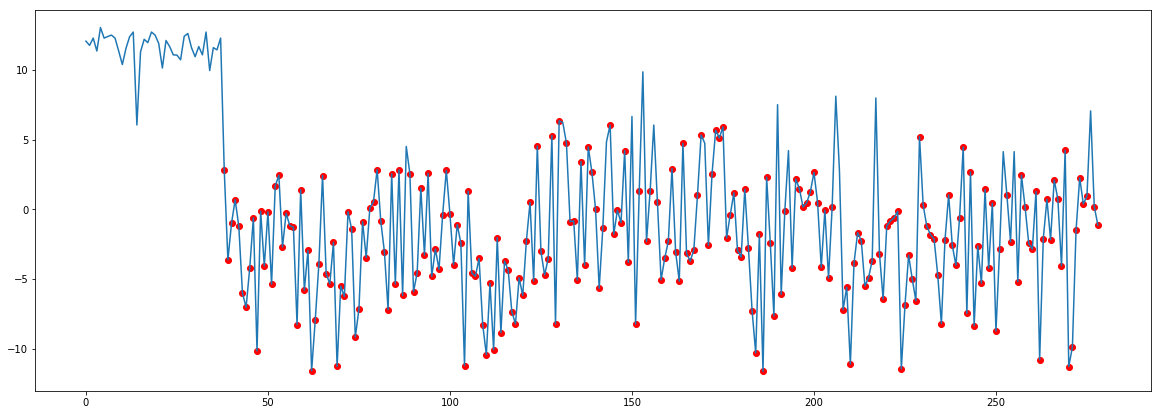

<Figure size 432x288 with 0 Axes>

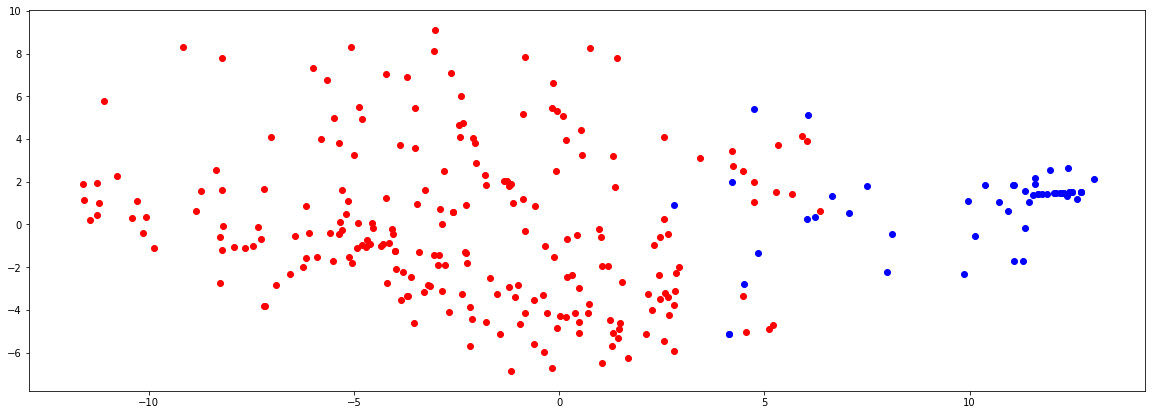

In [59]:
#using one class SVM

from sklearn.svm import OneClassSVM

#fit model
oneclass = OneClassSVM(kernel='linear', nu=0.9691)#0.99778)
oneclass.fit(trainData[params])

#predict anomalies
tempanomalyPredictionSVM = oneclass.predict(testData[params])
anomalyPredictionSVM = tempanomalyPredictionSVM == 1

plot_anomalies_in_1D(z_score, anomalyPredictionSVM)
generate_metrics(anomalyPredictionSVM, testData['class'])

plot_anomalies_in_2D(z2_score, anomalyPredictionSVM)

accuracy =  0.8172043010752689 ,detection rate = 0.7883817427385892 
false positive rate =  0.0 ,false negative rate = 0.1827956989247312


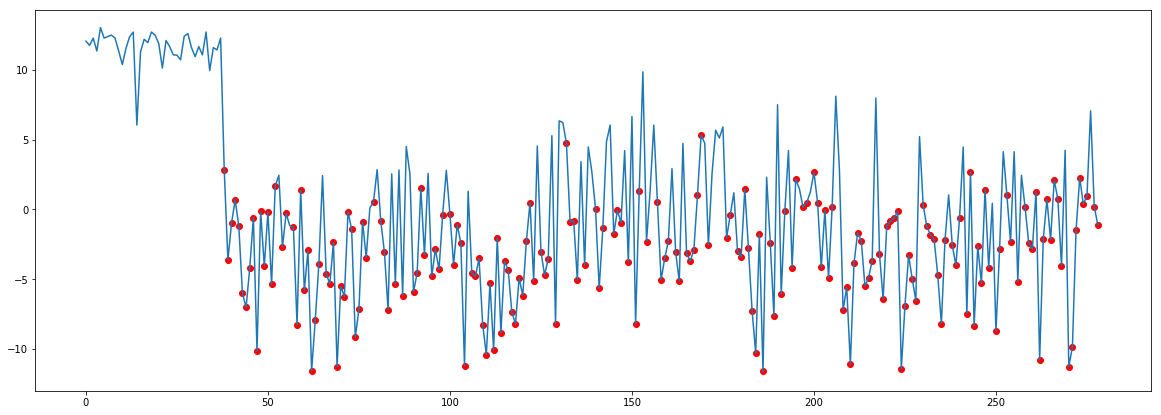

<Figure size 432x288 with 0 Axes>

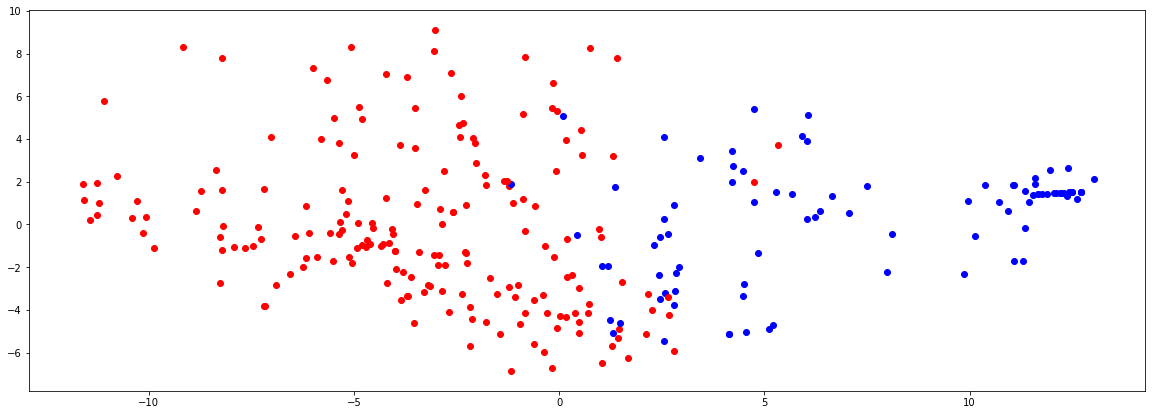

In [70]:
#using lof
#lof is based on KNN

from sklearn.neighbors import LocalOutlierFactor

#fit model
lof = LocalOutlierFactor(novelty = True,contamination = 0.5, n_neighbors = min(len(trainData),1000))
lof.fit(trainData[params])

#predict anomalies
tempanomalyPredictionLOF = lof.predict(testData[params])
anomalyPredictionLOF = tempanomalyPredictionLOF == -1

plot_anomalies_in_1D(z_score, anomalyPredictionLOF)
generate_metrics(anomalyPredictionLOF, testData['class'])

plot_anomalies_in_2D(z2_score, anomalyPredictionLOF)